In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt

## Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
Mobile Games AB Testing with Cookie Cats


In [13]:
df = pd.read_csv('cookie_cats.csv')

In [14]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [17]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


## Проверка наличия повторяющихся пользователей

In [18]:
df["userid"].count() == df["userid"].nunique()

True

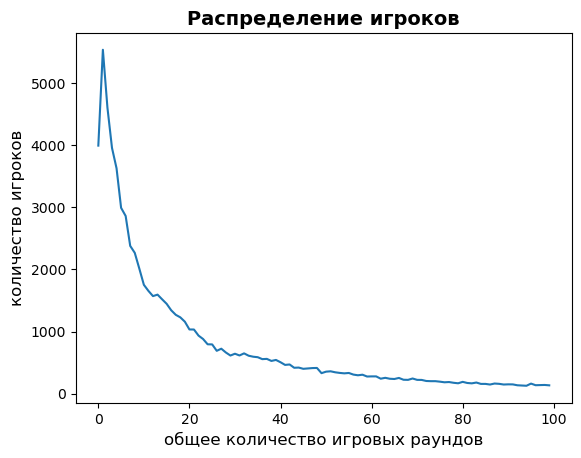

In [19]:

plot_df = df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("общее количество игровых раундов", size=12)
plt.ylabel("количество игроков", size=12)
plt.show()

In [20]:

display(df.groupby("version")[["userid"]].nunique())
n2, n1 = df.version.value_counts()

,userid
version,
gate_30,44700
gate_40,45489


выборки одинаковые ( - следовательно их вес одинаковый - не нужно на это делать поправку)

In [21]:

df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"Коэффициент удержания за 1 день: {round(df_retention[0],2)}% \
      \nКоэффициент удержания за 7 дней: {round(df_retention[1],2)}%")

Коэффициент удержания за 1 день: 44.52%       
Коэффициент удержания за 7 дней: 18.61%


## Определим проценты удержания. Какой процент игроков возвращается через день и неделю

In [23]:
retention = df[["retention_1","retention_7"]].mean()*100
print(f"Дневное удержание: {round(retention[0],2)}% \
      \nНедельное удержание: {round(retention[1],2)}%")

Дневное удержание: 44.52%       
Недельное удержание: 18.61%


Удержание по каждой версии

In [27]:
gate_30 = df.query('version == "gate_30" and retention_1 == True and retention_7 == True').userid.count()
gate_40 = df.query('version == "gate_40" and retention_1 == True and retention_7 == True').userid.count()
print(f"Версия gate_30: {gate_30} \
      \nВерсия gate_40: {gate_40}")

Версия gate_30: 6676       
Версия gate_40: 6506


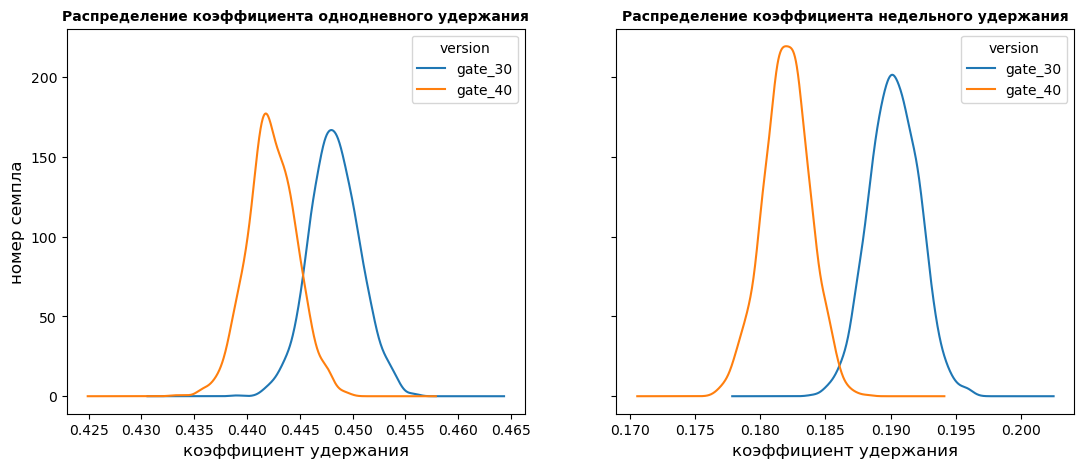

In [30]:
ret_1d = []
ret_7d = []
round_sum = []
for i in range(1500):
    mean_ret_1d = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    mean_ret_7d = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    mean_round_sum = df.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()
    ret_1d.append(mean_ret_1d)
    ret_7d.append(mean_ret_7d)
    round_sum.append(mean_round_sum)
    
ret_1d = pd.DataFrame(ret_1d)
ret_7d = pd.DataFrame(ret_7d)
round_sum = pd.DataFrame(round_sum)

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

ret_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания",size=12)
ax1.set_ylabel("номер семпла",size=12)
ax1.set_title("Распределение коэффициента однодневного удержания", fontweight="bold",size=10)

ret_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания",size=12)
ax2.set_title("Распределение коэффициента недельного удержания", fontweight="bold",size=10)
plt.show()
plt.show()

In [ ]:
Видно что 30 версия выигрывает у 40. Нужно определить вероятность с которой удержание и количество раундов для 30 версии будет больше, чем для 40


In [31]:
# Расчет вероятности для дневного коэффициента
prob_1 = (((ret_1d['gate_30'] - ret_1d['gate_40']) / ret_1d['gate_40'] * 100)>0).sum()/len(((ret_1d['gate_30'] - ret_1d['gate_40']) / ret_1d['gate_40'] * 100))

# Расчет вероятности для недельного коэффициента
prob_7 = (((ret_7d['gate_30'] - ret_7d['gate_40']) / ret_7d['gate_40'] * 100)>0).sum()/len(((ret_7d['gate_30'] - ret_7d['gate_40']) / ret_7d['gate_40'] * 100))

# Расчет вероятности для среднего количества раундов
prob_round = (((round_sum['gate_30'] - round_sum['gate_40']) / round_sum['gate_40'] * 100)>0).sum()/len(((round_sum['gate_30'] - round_sum['gate_40']) / round_sum['gate_40'] * 100))

print(f"Вероятность, что коэффициент дневного удержания будет выше для версии 30 = {round(prob_1*100,2)}% \
      \nВероятность, что коэффициент недельного удержания будет выше для версии 30: {round(prob_7*100,2)}% \
      \nВероятность, что среднее количество раундов будет выше для версии 30: {round(prob_round*100,2)}% ")

Вероятность, что коэффициент дневного удержания будет выше для версии 30 = 96.07%       
Вероятность, что коэффициент недельного удержания будет выше для версии 30: 99.93%       
Вероятность, что среднее количество раундов будет выше для версии 30: 79.67% 


## Выводы
В результате bootstrap анализа вероятность дневного и недельного удержаения в старой версии больше 90%. 
Рекомендация по результатам исследования набора данных: не стоит переходить на версию 40. 
